In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import optuna
from sklearn.inspection import PartialDependenceDisplay
import shap

In [54]:
# import data
df = pd.read_csv('/Users/philipp/Documents/02_Master_Uni/Uni_Tübingen/Semester_1/06 Data Literacy/02 Project/penguins_final_with_era5.csv')

In [101]:
df_base = df.copy()

In [102]:
df_base = df_base.drop(columns=['Unnamed: 0'])

In [37]:
# check for duplicates based on date_gmt and track_id
print(df_base.duplicated(subset=['date_gmt', 'track_id']).sum())

0


In [48]:
# df = df[(df['common_name'] == 'Adelie Penguin') & (df['colony_name'] == 'King George Island')].copy()
df_base = df_base[(df_base['common_name'] == 'Adelie Penguin')].copy()
df_base['date_gmt'] = pd.to_datetime(df_base['date_gmt'])
df_base = df_base.sort_values(by='date_gmt')

# ----------------------------
# Feature Engineering on Raw Data
df_base['day_of_year'] = df_base['date_gmt'].dt.dayofyear
df_base['month'] = df_base['date_gmt'].dt.month

# ----------------------------
# Aggregate Data Daily (Summarize the Cohort Movement)
# Aggregate by the date (ignoring time) to compute daily averages.
df_base['date'] = df_base['date_gmt'].dt.date
daily_df = df_base.groupby('date').agg({
    'km_to_colony_mean': 'mean',
    'tp': 'mean',
    't2m': 'mean',
    'sst': 'mean',
    'siconc': 'mean',
    'sd': 'mean',
    'rsn': 'mean',
    'avg_smr': 'mean',
    'month': 'first',
    'day_of_year': 'first'
}).reset_index()
daily_df['n_records'] = df_base.groupby('date').size().values

# Filter out days with very few observations.
min_records_per_day = 1
daily_df = daily_df[daily_df['n_records'] >= min_records_per_day]
print(f"After aggregation, {len(daily_df)} daily observations remain.")

# ----------------------------
# Create additional temporal features (optional)
daily_df['day_of_year_sin'] = np.sin(2 * np.pi * daily_df['day_of_year'] / 365.0)
daily_df['day_of_year_cos'] = np.cos(2 * np.pi * daily_df['day_of_year'] / 365.0)
daily_df['month_sin'] = np.sin(2 * np.pi * daily_df['month'] / 12.0)
daily_df['month_cos'] = np.cos(2 * np.pi * daily_df['month'] / 12.0)


After aggregation, 100 daily observations remain.


In [49]:
# filter daily_df for the time period of interest
daily_df['date'] = pd.to_datetime(daily_df['date'])

daily_df = daily_df[(daily_df['date'] >= '2003-01-01') & (daily_df['date'] <= '2017-12-31')].copy()

In [50]:
# identify gaps in the data
threshold = 10 # one week no data is alright
daily_df['date'] = pd.to_datetime(daily_df['date'])
daily_df = daily_df.sort_values(by='date')
daily_df['gap'] = daily_df['date'].diff().dt.days > threshold
print(f"Identified {daily_df['gap'].sum()} gaps in the data.")

Identified 0 gaps in the data.


In [51]:
daily_df['group'] = daily_df['gap'].cumsum()
groups = [group for _, group in daily_df.groupby('group')]
groups = [g for g in groups if len(g) >= 100]

# filter daily_df['group'] for 100 days or more
daily_df = daily_df[daily_df['group'].isin([g['group'].iloc[0] for g in groups])].copy()

daily_df = daily_df.drop(columns=['gap'])

In [42]:
# Define climate features
# Smooth the climate features using a 7-day rolling mean.
smoothing_window = 7
climate_vars = ['tp', 't2m', 'sst', 'siconc', 'sd', 'rsn', 'avg_smr']
for var in climate_vars:
    daily_df[f'{var}_smoothed'] = daily_df[var].rolling(window=smoothing_window, center=True).mean()

# ----------------------------
# Drop any remaining missing values (due to smoothing near boundaries).
daily_df = daily_df.dropna()


climate_vars = ['tp_smoothed', 't2m_smoothed', 'sst_smoothed', 'siconc_smoothed',
                'sd_smoothed', 'rsn_smoothed', 'avg_smr_smoothed']
features = climate_vars
target = 'km_to_colony_mean'

# Train models on each group independently
results = []
for group_id, group_df in daily_df.groupby('group'):
    print(f"\nTraining on Time Period {group_id} (from {group_df['date'].min()} to {group_df['date'].max()})")

    # Extract features and target, dropping NaN values
    X = group_df[features].dropna()
    y = group_df[target].loc[X.index]  # Ensure matching indices

    if len(X) < 2:  # Skip groups that are too small
        print(f"Skipping group {group_id} due to insufficient data.")
        continue

    # Train-test split (80-20)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  # Time series split

    # Standardize features using training data only
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train Ridge and Lasso
    ridge_model = Ridge(alpha=1.0)
    lasso_model = Lasso(alpha=0.1)
    
    ridge_model.fit(X_train_scaled, y_train)
    lasso_model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred_ridge = ridge_model.predict(X_test_scaled)
    y_pred_lasso = lasso_model.predict(X_test_scaled)

    # Evaluate models
    ridge_r2 = r2_score(y_test, y_pred_ridge)
    ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
    lasso_r2 = r2_score(y_test, y_pred_lasso)
    lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

    results.append({
        "Group": group_id,
        "Start": group_df['date'].min(),
        "End": group_df['date'].max(),
        "Ridge R²": ridge_r2,
        "Ridge RMSE": ridge_rmse,
        "Lasso R²": lasso_r2,
        "Lasso RMSE": lasso_rmse
    })

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)
print("\nPerformance across different time periods:")
print(results_df)



Training on Time Period 0 (from 2016-11-09 00:00:00 to 2017-02-11 00:00:00)

Performance across different time periods:
   Group      Start        End  Ridge R²  Ridge RMSE  Lasso R²  Lasso RMSE
0      0 2016-11-09 2017-02-11  0.753476   33.610757  0.793122   30.789752


In [52]:
print(daily_df.columns)

Index(['date', 'km_to_colony_mean', 'tp', 't2m', 'sst', 'siconc', 'sd', 'rsn',
       'avg_smr', 'month', 'day_of_year', 'n_records', 'day_of_year_sin',
       'day_of_year_cos', 'month_sin', 'month_cos', 'group'],
      dtype='object')


In [53]:
# print number of daily_df rows
print(len(daily_df))

100


# Models
## Prepare new dataframe with all data

In [161]:
df_base = df.copy()
df_base = df_base.drop(columns=['Unnamed: 0'])

In [162]:
print(df_base.columns)

Index(['track_id', 'date_gmt', 'latitude_mean', 'longitude_mean',
       'lat_colony_mean', 'lon_colony_mean', 'km_to_colony_mean',
       'km_since_last_measure_mean', 'delta_km_north_mean',
       'delta_km_south_mean', 'delta_km_east_mean', 'delta_km_west_mean',
       'minutes_since_last_measure_mean', 'latitude_std', 'longitude_std',
       'lat_colony_std', 'lon_colony_std', 'km_to_colony_std',
       'km_since_last_measure_std', 'delta_km_north_std', 'delta_km_south_std',
       'delta_km_east_std', 'delta_km_west_std',
       'minutes_since_last_measure_std', 'latitude_min', 'longitude_min',
       'lat_colony_min', 'lon_colony_min', 'km_to_colony_min',
       'km_since_last_measure_min', 'delta_km_north_min', 'delta_km_south_min',
       'delta_km_east_min', 'delta_km_west_min',
       'minutes_since_last_measure_min', 'latitude_max', 'longitude_max',
       'lat_colony_max', 'lon_colony_max', 'km_to_colony_max',
       'km_since_last_measure_max', 'delta_km_north_max', 'delta

In [156]:
# df_base = df_base[(df_base['common_name'] == 'Adelie Penguin')].copy()
# df_base['date_gmt'] = pd.to_datetime(df_base['date_gmt'])
# df_base = df_base.sort_values(by='date_gmt')

# # ----------------------------
# # Feature Engineering on Raw Data
# df_base['day_of_year'] = df_base['date_gmt'].dt.dayofyear
# df_base['month'] = df_base['date_gmt'].dt.month

# # ----------------------------
# # Aggregate Data Daily (Summarize the Cohort Movement)
# # Aggregate by the date (ignoring time) to compute daily averages.
# df_base['date'] = df_base['date_gmt'].dt.date


# # HOW CAN I TREAT COLONY NAME? WHEN I AGGREGATE THE DATA, I LOSE THE COLONY NAME --> One hot enncoding and then treat it as probability?
# df_base = df_base.groupby('date').agg({
#     'km_to_colony_mean': 'mean',
#     'tp': 'mean',
#     't2m': 'mean',
#     'sst': 'mean',
#     'siconc': 'mean',
#     'sd': 'mean',
#     'rsn': 'mean',
#     'avg_smr': 'mean',
#     'month': 'first',
#     'day_of_year': 'first'
# }).reset_index()

# print(f"After aggregation, {len(df_base)} daily observations remain.")

After aggregation, 940 daily observations remain.


In [165]:
# filter by species
df_adelie = df_base[(df_base['common_name'] == 'Adelie Penguin')].copy()

In [164]:
df_adelie = df_base.copy()

In [170]:
print(len(df_adelie))
print(df_adelie.columns)

6030
Index(['track_id', 'date_gmt', 'latitude_mean', 'longitude_mean',
       'lat_colony_mean', 'lon_colony_mean', 'km_to_colony_mean',
       'km_since_last_measure_mean', 'delta_km_north_mean',
       'delta_km_south_mean', 'delta_km_east_mean', 'delta_km_west_mean',
       'minutes_since_last_measure_mean', 'latitude_std', 'longitude_std',
       'lat_colony_std', 'lon_colony_std', 'km_to_colony_std',
       'km_since_last_measure_std', 'delta_km_north_std', 'delta_km_south_std',
       'delta_km_east_std', 'delta_km_west_std',
       'minutes_since_last_measure_std', 'latitude_min', 'longitude_min',
       'lat_colony_min', 'lon_colony_min', 'km_to_colony_min',
       'km_since_last_measure_min', 'delta_km_north_min', 'delta_km_south_min',
       'delta_km_east_min', 'delta_km_west_min',
       'minutes_since_last_measure_min', 'latitude_max', 'longitude_max',
       'lat_colony_max', 'lon_colony_max', 'km_to_colony_max',
       'km_since_last_measure_max', 'delta_km_north_max', '

In [171]:
# one hot encode colony name
df_adelie = pd.get_dummies(df_adelie, columns=['colony_name'])


KeyError: "None of [Index(['colony_name'], dtype='object')] are in the [columns]"

In [172]:
print(df_adelie.columns)

Index(['track_id', 'date_gmt', 'latitude_mean', 'longitude_mean',
       'lat_colony_mean', 'lon_colony_mean', 'km_to_colony_mean',
       'km_since_last_measure_mean', 'delta_km_north_mean',
       'delta_km_south_mean', 'delta_km_east_mean', 'delta_km_west_mean',
       'minutes_since_last_measure_mean', 'latitude_std', 'longitude_std',
       'lat_colony_std', 'lon_colony_std', 'km_to_colony_std',
       'km_since_last_measure_std', 'delta_km_north_std', 'delta_km_south_std',
       'delta_km_east_std', 'delta_km_west_std',
       'minutes_since_last_measure_std', 'latitude_min', 'longitude_min',
       'lat_colony_min', 'lon_colony_min', 'km_to_colony_min',
       'km_since_last_measure_min', 'delta_km_north_min', 'delta_km_south_min',
       'delta_km_east_min', 'delta_km_west_min',
       'minutes_since_last_measure_min', 'latitude_max', 'longitude_max',
       'lat_colony_max', 'lon_colony_max', 'km_to_colony_max',
       'km_since_last_measure_max', 'delta_km_north_max', 'delta

In [173]:
smoothing_window = 7
climate_vars = ['tp', 't2m', 'sst', 'siconc', 'sd', 'rsn', 'avg_smr']
for var in climate_vars:
    df_adelie[f'{var}_smoothed'] = df_adelie[var].rolling(window=smoothing_window, center=True).mean()


In [174]:
needed_vars = ['tp_smoothed', 't2m_smoothed', 'sst_smoothed', 'siconc_smoothed',
                'sd_smoothed', 'rsn_smoothed', 'avg_smr_smoothed', 
                'colony_name_Admiralty Bay', 'colony_name_Hope Bay',
                'colony_name_King George Island',
                'colony_name_Powell Island/Peng colony',
                'colony_name_Signy Island/Gourlay',
                'colony_name_Signy Island/North Point']

df_test = df_adelie[needed_vars]
print(df_test.columns)

Index(['tp_smoothed', 't2m_smoothed', 'sst_smoothed', 'siconc_smoothed',
       'sd_smoothed', 'rsn_smoothed', 'avg_smr_smoothed',
       'colony_name_Admiralty Bay', 'colony_name_Hope Bay',
       'colony_name_King George Island',
       'colony_name_Powell Island/Peng colony',
       'colony_name_Signy Island/Gourlay',
       'colony_name_Signy Island/North Point'],
      dtype='object')


# prep

In [178]:

# Drop time-based features and keep only climate variables
needed_vars = ['tp_smoothed', 't2m_smoothed', 'sst_smoothed', 'siconc_smoothed',
                'sd_smoothed', 'rsn_smoothed', 'avg_smr_smoothed', 'minutes_since_last_measure_mean',
                'colony_name_Admiralty Bay', 'colony_name_Hope Bay',
                'colony_name_King George Island',
                'colony_name_Powell Island/Peng colony',
                'colony_name_Signy Island/Gourlay',
                'colony_name_Signy Island/North Point']
target = 'km_to_colony_mean'

X = df_adelie[needed_vars]
y = df_adelie[target]

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## Regression model (basic without tuning)

In [179]:
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
ridge_preds = ridge_model.predict(X_test)

lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)
lasso_preds = lasso_model.predict(X_test)

# Evaluate performance
print("Ridge Regression:")
evaluate_model(y_test, ridge_preds, "Ridge")

print("Lasso Regression:")
evaluate_model(y_test, lasso_preds, "Lasso")

Ridge Regression:
Ridge - R²: 0.628, RMSE: 161.646
Lasso Regression:
Lasso - R²: 0.628, RMSE: 161.641


In [181]:
from sklearn.neural_network import MLPRegressor

mlp_model = MLPRegressor(hidden_layer_sizes=(128, 64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)
mlp_preds = mlp_model.predict(X_test)

# Evaluate performance
evaluate_model(y_test, mlp_preds, "Neural Network (MLP)")


Neural Network (MLP) - R²: 0.706, RMSE: 143.751


## Basic model without tuning

In [ ]:


# ----------------------------
# Train Random Forest Model
# ----------------------------
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# ----------------------------
# Train XGBoost Model
# ----------------------------
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# ----------------------------
# Evaluate Models
# ----------------------------
def evaluate_model(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{model_name} - R²: {r2:.3f}, RMSE: {rmse:.3f}")

evaluate_model(y_test, rf_preds, "Random Forest")
evaluate_model(y_test, xgb_preds, "XGBoost")


Random Forest - R²: 0.893, RMSE: 91.592
XGBoost - R²: 0.887, RMSE: 93.986


## Bayesian Optimization

In [140]:
def objective_rf(trial):
    """Objective function for Bayesian Optimization of Random Forest."""
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 6)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return r2_score(y_test, preds)


In [141]:
study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_rf, n_trials=100)  # Try n_trials different sets of hyperparameters

# Print best parameters
print(f"Best Random Forest Params: {study_rf.best_params}")
print(f"Best Random Forest R²: {study_rf.best_value:.3f}")


[I 2025-02-08 14:07:58,249] A new study created in memory with name: no-name-72b08902-1b05-47a1-a5b0-940c5f1edeab
[I 2025-02-08 14:07:59,420] Trial 0 finished with value: 0.8311951129633679 and parameters: {'n_estimators': 431, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8311951129633679.
[I 2025-02-08 14:08:00,569] Trial 1 finished with value: 0.869826049279124 and parameters: {'n_estimators': 364, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.869826049279124.
[I 2025-02-08 14:08:02,436] Trial 2 finished with value: 0.8852314939247354 and parameters: {'n_estimators': 486, 'max_depth': 40, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.8852314939247354.
[I 2025-02-08 14:08:02,955] Trial 3 finished with value: 0.750414195540523 and parameters: {'n_estimators': 274, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.8

Best Random Forest Params: {'n_estimators': 285, 'max_depth': 31, 'min_samples_split': 2, 'min_samples_leaf': 1}
Best Random Forest R²: 0.898


In [142]:
def objective_xgb(trial):
    """Objective function for Bayesian Optimization of XGBoost."""
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)

    model = XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42
    )

    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return r2_score(y_test, preds)


In [143]:
study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=100)  # Try n_trials different sets of hyperparameters

# Print best parameters
print(f"Best XGBoost Params: {study_xgb.best_params}")
print(f"Best XGBoost R²: {study_xgb.best_value:.3f}")


[I 2025-02-08 14:10:18,236] A new study created in memory with name: no-name-c16e4c9d-d7ca-48bf-a016-3a4bde19f394
[I 2025-02-08 14:10:18,631] Trial 0 finished with value: 0.8824647711173093 and parameters: {'n_estimators': 386, 'learning_rate': 0.18599806041971123, 'max_depth': 4, 'subsample': 0.7873034924780056, 'colsample_bytree': 0.9113821804396594}. Best is trial 0 with value: 0.8824647711173093.
[I 2025-02-08 14:10:19,628] Trial 1 finished with value: 0.9048321074569083 and parameters: {'n_estimators': 257, 'learning_rate': 0.07740509201617814, 'max_depth': 10, 'subsample': 0.9607140830159291, 'colsample_bytree': 0.9666193082402638}. Best is trial 1 with value: 0.9048321074569083.
[I 2025-02-08 14:10:20,626] Trial 2 finished with value: 0.9076715213829174 and parameters: {'n_estimators': 347, 'learning_rate': 0.031061580235820934, 'max_depth': 10, 'subsample': 0.6068139788957296, 'colsample_bytree': 0.6605544332369386}. Best is trial 2 with value: 0.9076715213829174.
[I 2025-02-08

Best XGBoost Params: {'n_estimators': 472, 'learning_rate': 0.030658909845062445, 'max_depth': 10, 'subsample': 0.973889261268593, 'colsample_bytree': 0.8183452221054237}
Best XGBoost R²: 0.913


In [144]:
# Train optimized Random Forest
rf_best = RandomForestRegressor(**study_rf.best_params, random_state=42, n_jobs=-1)
rf_best.fit(X_train, y_train)
rf_best_preds = rf_best.predict(X_test)

# Train optimized XGBoost
xgb_best = XGBRegressor(**study_xgb.best_params, random_state=42)
xgb_best.fit(X_train, y_train)
xgb_best_preds = xgb_best.predict(X_test)

# Evaluate models
evaluate_model(y_test, rf_best_preds, "Random Forest (Bayesian Tuned)")
evaluate_model(y_test, xgb_best_preds, "XGBoost (Bayesian Tuned)")


Random Forest (Bayesian Tuned) - R²: 0.898, RMSE: 89.404
XGBoost (Bayesian Tuned) - R²: 0.913, RMSE: 82.269


### Random Forest Feature Importance

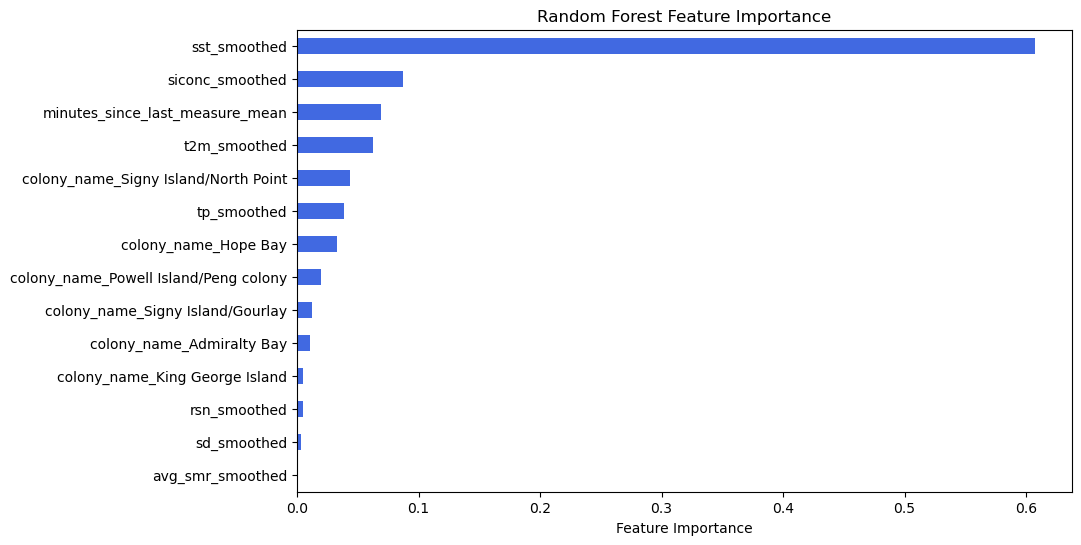

In [146]:
# Get feature importances from RF
rf_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)

# Plot
plt.figure(figsize=(10, 6))
rf_importances.sort_values().plot(kind='barh', color='royalblue')
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

### XGBoost feature importance

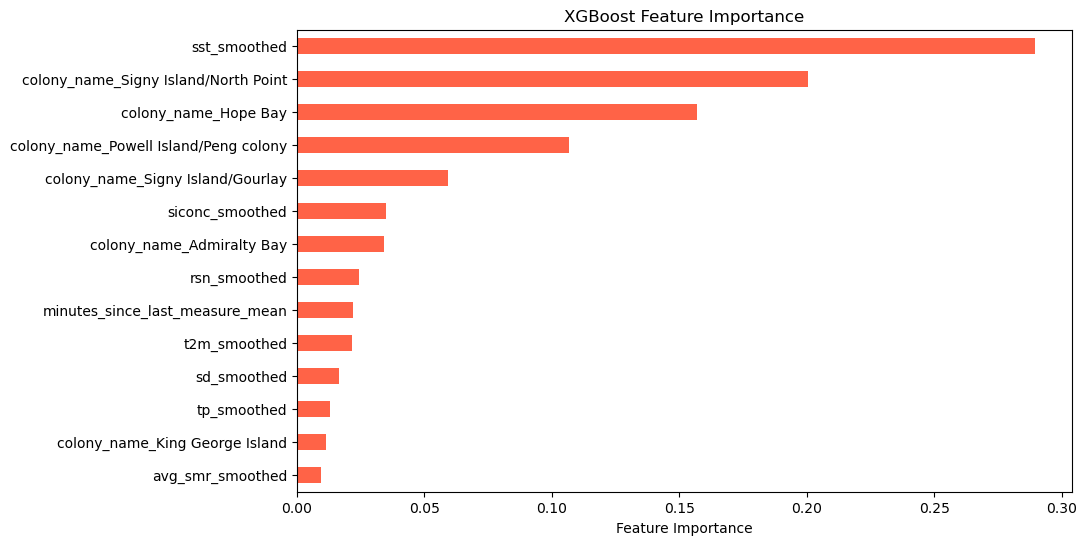

In [147]:
xgb_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)

# Plot
plt.figure(figsize=(10, 6))
xgb_importances.sort_values().plot(kind='barh', color='tomato')
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.show()


### SHAP

 96%|=================== | 580/603 [00:17<00:00]       

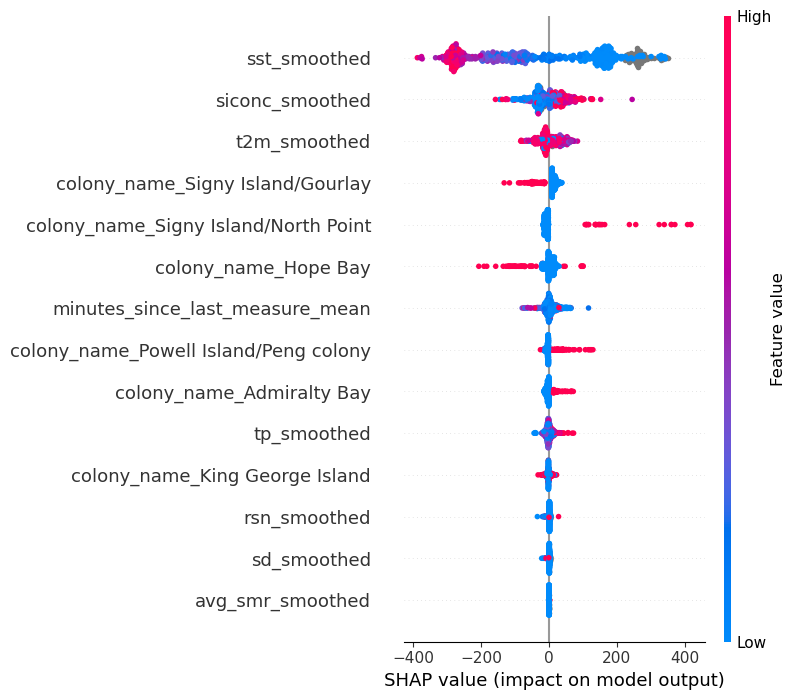

In [149]:
# Explain RF model with SHAP
explainer = shap.Explainer(rf_model, X_train)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)